In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.sparse import identity

In [2]:
 # Load in model predictions

data = np.load('/home/jbassham/jack/thesis-rough/data/model-output/lr-cf/nh/20260107_164301/preds_lr_cf_nh19922020_20260107_164301.npz')

upred = data['y_pred'][:,0,:,:]
vpred = data['y_pred'][:,1,:,:]

utrue = data['y_true'][:,0,:,:]
vtrue = data['y_true'][:,1,:,:]


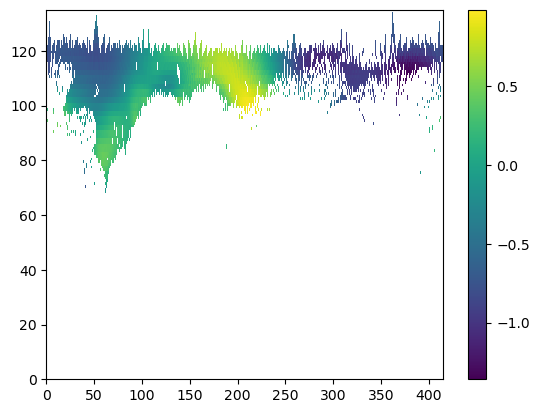

In [3]:
plt.pcolormesh(upred[0,:,:])
plt.colorbar()
plt.show()

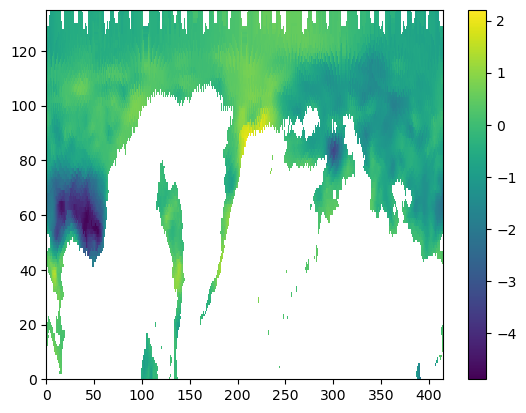

In [4]:
plt.pcolormesh(utrue[0,:,:])
plt.colorbar()
plt.show()

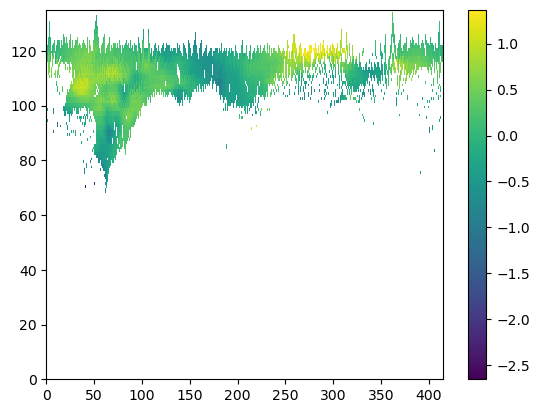

In [5]:
plt.pcolormesh((utrue[0,:,:] - upred[0,:,:]))
plt.colorbar()
plt.show()

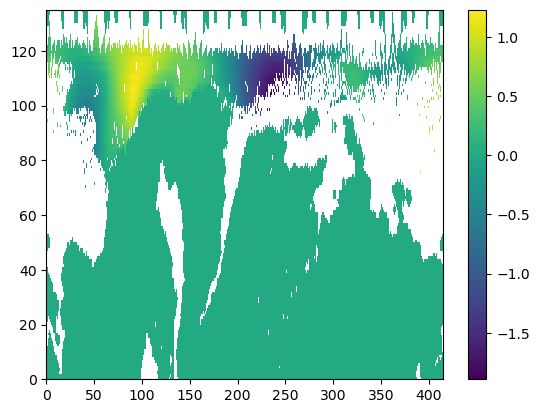

In [6]:
plt.pcolormesh(vpred[0,:,:])
plt.colorbar()
plt.show()

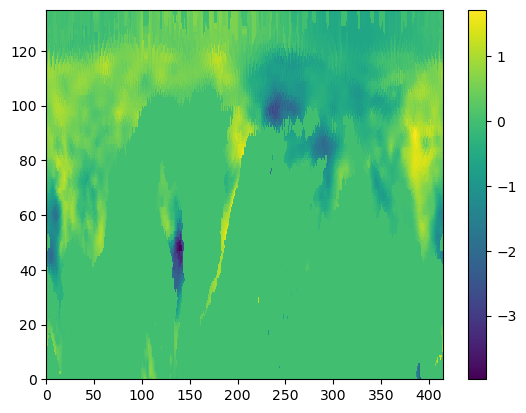

In [7]:
plt.pcolormesh(vtrue[0,:,:])
plt.colorbar()
plt.show()

In [8]:
data = np.load('/home/jbassham/jack/thesis-rough/data/model-output/lr-cf/nh/20260107_164301/coef_fit_lr_cf_nh19922020_20260107_164301.npz')

ufit = data['fit_tr'][:,0,:,:]
vfit = data['fit_tr'][:,1,:,:]

utrue_tr = data['true_tr'][:,0,:,:]
vtrue_tr = data['true_tr'][:,1,:,:]

m = data['m']

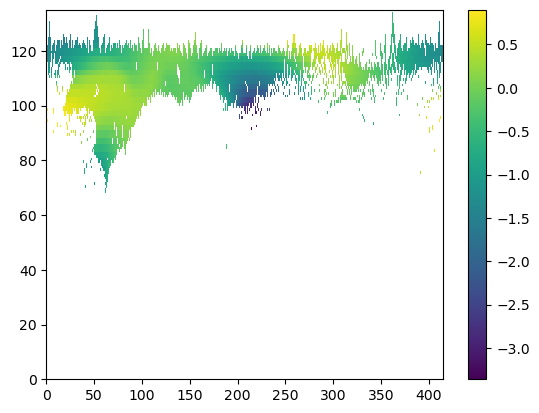

In [9]:
plt.pcolormesh(ufit[0,:,:])
plt.colorbar()

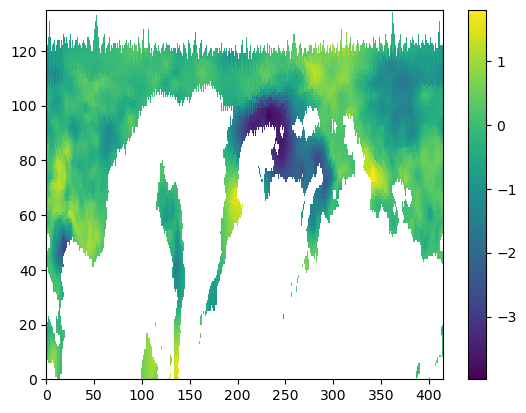

In [10]:
plt.pcolormesh(utrue_tr[0,:,:])
plt.colorbar()


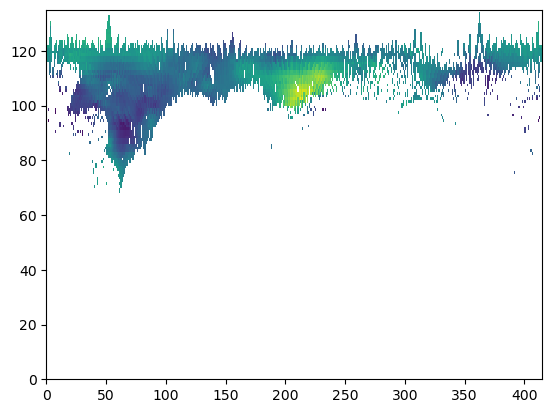

In [11]:
plt.pcolormesh(utrue_tr[0,:,:] - ufit[0,:,:])

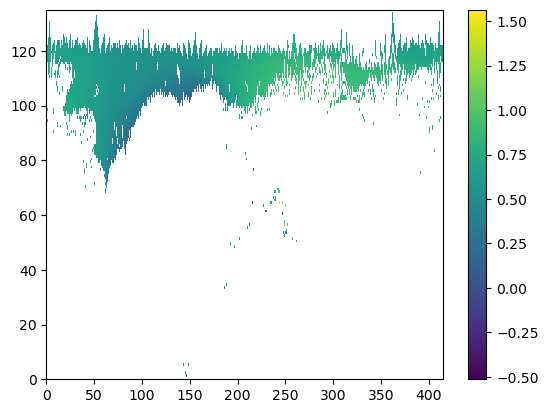

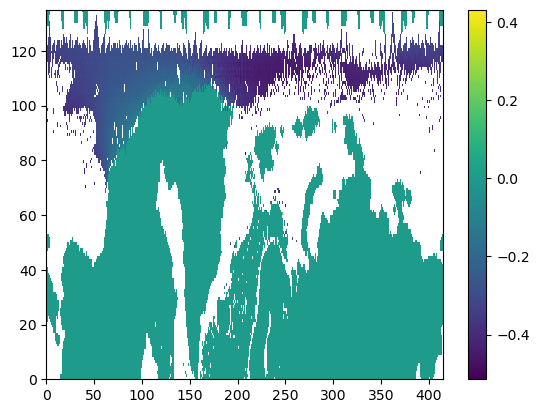

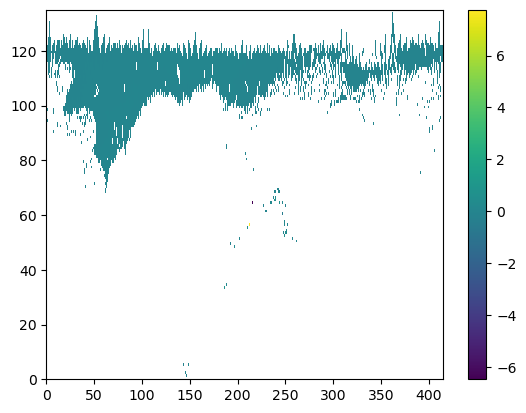

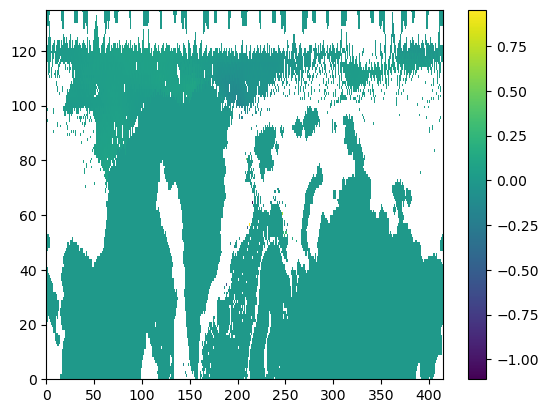

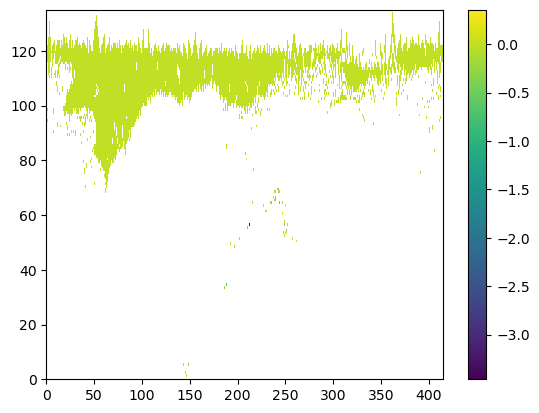

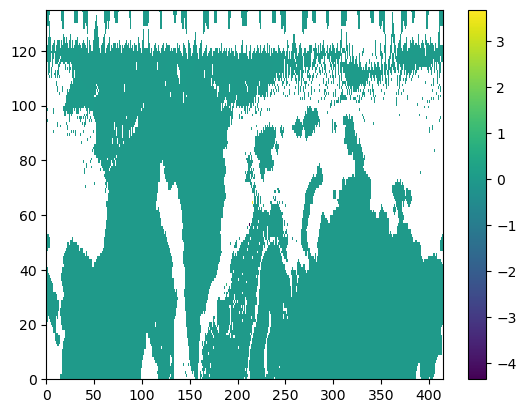

In [12]:
for ms in m:
    plt.pcolormesh(ms)
    plt.colorbar()
    plt.show()



In [13]:
def lr_train(x_train, y_train):

    # TODO dynamic number of input channels and coefficients

    # Define number of input channels for gram matrix
    nin = 3 # complex wind (za), complex ice concentration (zci), complex constant 

    # Define number of complex coefficients
    nzm = 3 # A, B, C
   
    # Get dimensions for output arrays
    nt, _, nlat, nlon = np.shape(y_train)

    # Unpack target arrays
    ui_t0 = y_train[:,0,:,:]
    vi_t0 = y_train[:,1,:,:]

    # Unpack feature arrays
    ua_t0 = x_train[:,0,:,:]
    va_t0 = x_train[:,1,:,:]
    ci_t1 = x_train[:,2,:,:]

    # TODO fix nin for zm_all (just a coincidence that it matches with nin)
    # need A, B, C (za, ua, constant)

    # TODO switch order of gram matrix so constant is at end?
    # for consisitency with lr equation Ax + Bx + C

    # Initialize output arrays
    ztrue_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # true present day ice velocity vector, complex
    zfit_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # present day fit ice velocity, complex
    zm_all = np.full((nzm, nlat, nlon), np.nan, dtype = complex) # lr coefficients (A, B, C), complex
    
    # Iterate through each latitude, longitude gridpoint
    for ilat in range(nlat):
        for ilon in range(nlon):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(ui_t0[:,ilat,ilon], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    ui_t0_filt = ui_t0[true_mask,ilat,ilon]
                    vi_t0_filt = vi_t0[true_mask,ilat,ilon]
                    ua_t0_filt = ua_t0[true_mask,ilat,ilon]
                    va_t0_filt = va_t0[true_mask,ilat,ilon]
                    ci_t1_filt = ci_t1[true_mask,ilat,ilon]

                    # Convert to complex
                    zi_t0 = ui_t0_filt + vi_t0_filt*1j # Complex 'today' ice velocity vector       
                    za_t0 = ua_t0_filt + va_t0_filt*1j # Complex 'today' wind vector
                    zci_t1 = ci_t1_filt + ci_t1_filt*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    ztrue_all[true_mask, ilat, ilon] = zi_t0

                    # Define size of valid batch at current grid point
                    nt_ij = len(ui_t0_filt)

                    # Define gram matrix
                    G = np.ones(((nt_ij, nin)), dtype = complex) 

                    G[:,0] = za_t0 # Present day wind velocity, complex
                    G[:,1] = zci_t1 # Previous day ice concentration, complex
                    
                    # NOTE last column of G constant

                    # Define data matrix
                    d = zi_t0.T

                    # Solve for lr coefficients
                    zm = (LA.inv((G.conj().T @ G))) @ G.conj().T @ d

                    # Save lr coefficients
                    for izm in range(len(zm)):
                        zm_all[izm, ilat, ilon] = zm[izm]

                    # Calculate fit
                    zfit = G @ zm
                    
                    # Store predicted complex ice velocity vectors at valid points
                    zfit_all[true_mask, ilat, ilon] = zfit

                except Exception as e:
                    print(f"Error at lat={ilat}, lon={ilon}: {e}")

        print(f'lat {ilat} complete')
        
    return zm_all, zfit_all, ztrue_all

In [14]:
def lr_test(x_test, y_test, zm):

    # TODO dynamic number of input channels and coefficients

    # Define number of input channels for gram matrix
    nin = 3 # complex wind (za), complex ice concentration (zci), complex constant 
   
    # Get dimensions for output arrays
    nt, _, nlat, nlon = np.shape(y_test)

    # Unpack target arrays
    ui_t0 = y_test[:,0,:,:]
    vi_t0 = y_test[:,1,:,:]

    # Unpack feature arrays
    ua_t0 = x_test[:,0,:,:]
    va_t0 = x_test[:,1,:,:]
    ci_t1 = x_test[:,2,:,:]
      
    # Initialize output arrays
    ztrue_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    zpred_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    
    # Iterate through each latitude, longitude gridpoint
    for ilat in range(nlat):
        for ilon in range(nlon):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(ui_t0[:,ilat,ilon], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    ui_t0_filt = ui_t0[true_mask,ilat,ilon]
                    vi_t0_filt = vi_t0[true_mask,ilat,ilon]
                    ua_t0_filt = ua_t0[true_mask,ilat,ilon]
                    va_t0_filt = va_t0[true_mask,ilat,ilon]
                    ci_t1_filt = ci_t1[true_mask,ilat,ilon]

                    # Convert to complex
                    zi_t0 = ui_t0_filt + vi_t0_filt*1j # Complex 'today' ice velocity vector       
                    za_t0 = ua_t0_filt + va_t0_filt*1j # Complex 'today' wind vector
                    zci_t1 = ci_t1_filt + ci_t1_filt*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    ztrue_all[true_mask, ilat, ilon] = zi_t0

                    # Define size of valid batch at current grid point
                    nt_ij = len(ui_t0_filt)

                    # Define gram matrix
                    G = np.ones(((nt_ij, nin)), dtype = complex) 

                    G[:,0] = za_t0 # Present day wind velocity, complex
                    G[:,1] = zci_t1 # Previous day ice concentration, complex
                    
                    # NOTE last column of G constant

                    # Define data matrix
                    d = zi_t0.T

                    # Get valid coefficients at grid point
                    zm_ij = zm[:,ilat,ilon]

                    # Calculate fit
                    zpred = G @ zm_ij
            
                    # Store predicted complex ice velocity vectors at valid points
                    zpred_all[true_mask, ilat, ilon] = zpred

                except Exception as e:
                    print(f"Error at lat={ilat}, lon={ilon}: {e}")

        print(f'ilat {ilat} complete')

    return zpred_all, ztrue_all

In [15]:
# Load in training data
data = np.load('/home/jbassham/jack/thesis-rough/data/lr-input/nh/20260107_164301/train_nh19922020_20260107_164301.npz')
x_train = data['x_train']
y_train = data['y_train']

# Load in testing data
data = np.load('/home/jbassham/jack/thesis-rough/data/lr-input/nh/20260107_164301/test_nh19922020_20260107_164301.npz')
x_test = data['x_test']
y_test = data['y_test']


In [16]:
# Get train batch dimensions
nt_tr, nout, nlat, nlon = np.shape(y_train)

# Get input channel dimensions
_, nin, _, _, = np.shape(x_train)

# TODO make coefficient dimension dynamic

# Get coefficient dimension
nm = nin + 1 # NOTE +1 for u and v complex concentration projections 
nm = nm + 2 # NOTE +2 for u and v constants (mean ~ 0) (constant column G[0])

# Get test batch dimensions
nt_te, _, _, _ = np.shape(y_test)

# Train model
zm, zfit_tr, ztrue_tr = lr_train(x_train, y_train)

# Initialize arrays for real training outputs
# NOTE two extra coefficients for u and v mean
m = np.full((nm, nlat, nlon), np.nan) # model coefficients, real
fit_tr = np.full((nt_tr, nout, nlat, nlon), np.nan) # training fit, real
true_tr = np.full((nt_tr, nout, nlat, nlon), np.nan) # training true, real

# TODO make loop or use advanced indexing for real and imaginary coefficients

# Convert training coefficients to real
m[0, :, :] = zm[0, :, :].real # C_uproj, (constant)
m[1, :, :] = zm[0, :, :].imag # C_vproj, (constant)
m[2, :, :] = zm[1, :, :].real # A_uproj, (ua_t0)
m[3, :, :] = zm[1, :, :].imag # A_uproj, (va_t0)
m[4, :, :] = zm[2, :, :].real # B_uproj, (ci_t1)
m[5, :, :] = zm[2, :, :].imag # B_uproj, (ci_t1)

# Convert training fit to real
fit_tr[:, 0, :, :] = zfit_tr.real # ui_t0, fit
fit_tr[:, 1, :, :] = zfit_tr.imag # vi_t0, fit

# Convert training true to real
true_tr[:, 0, :, :] = ztrue_tr.real # ui_t0, true
true_tr[:, 1, :, :] = ztrue_tr.imag # vi_t0, true

# # Save coeffients, fit
# np.savez(
#     os.path.join(PATH_DEST, f"coef_fit_{MODEL_STR}_{FSTR_END_OUT}.npz"),
#     m = m,
#     fit_tr = fit_tr,
#     true_tr = true_tr,
# )

Error at lat=0, lon=163: Singular matrix
Error at lat=0, lon=165: Singular matrix
Error at lat=0, lon=167: Singular matrix
Error at lat=0, lon=168: Singular matrix
lat 0 complete
Error at lat=1, lon=164: Singular matrix
Error at lat=1, lon=167: Singular matrix
Error at lat=1, lon=207: Singular matrix
lat 1 complete
Error at lat=2, lon=168: Singular matrix
Error at lat=2, lon=169: Singular matrix
Error at lat=2, lon=170: Singular matrix
Error at lat=2, lon=207: Singular matrix
Error at lat=2, lon=208: Singular matrix
lat 2 complete
Error at lat=3, lon=163: Singular matrix
Error at lat=3, lon=164: Singular matrix
lat 3 complete
Error at lat=4, lon=170: Singular matrix
Error at lat=4, lon=208: Singular matrix
lat 4 complete
Error at lat=5, lon=164: Singular matrix
Error at lat=5, lon=165: Singular matrix
Error at lat=5, lon=169: Singular matrix
Error at lat=5, lon=172: Singular matrix
Error at lat=5, lon=207: Singular matrix
Error at lat=5, lon=208: Singular matrix
Error at lat=5, lon=209

Error at lat=34, lon=211: Singular matrix
lat 34 complete
Error at lat=35, lon=204: Singular matrix
Error at lat=35, lon=215: Singular matrix
lat 35 complete
Error at lat=36, lon=193: Singular matrix
Error at lat=36, lon=202: Singular matrix
Error at lat=36, lon=209: Singular matrix
Error at lat=36, lon=219: Singular matrix
lat 36 complete
Error at lat=37, lon=198: Singular matrix
Error at lat=37, lon=207: Singular matrix
Error at lat=37, lon=218: Singular matrix
lat 37 complete
Error at lat=38, lon=195: Singular matrix
lat 38 complete
Error at lat=39, lon=192: Singular matrix
Error at lat=39, lon=199: Singular matrix
lat 39 complete
Error at lat=40, lon=196: Singular matrix
Error at lat=40, lon=198: Singular matrix
Error at lat=40, lon=207: Singular matrix
Error at lat=40, lon=208: Singular matrix
Error at lat=40, lon=210: Singular matrix
Error at lat=40, lon=215: Singular matrix
lat 40 complete
Error at lat=41, lon=198: Singular matrix
Error at lat=41, lon=207: Singular matrix
Error 

In [17]:
# Get predictions on test set
zpred_te, ztrue_te = lr_test(x_test, y_test, zm)

# Intialize arrays for test output predictions
# NOTE y notation used for consistency with CNN and plotting
y_pred = np.full((nt_te, nout, nlat, nlon), np.nan) 
y_true = np.full((nt_te, nout, nlat, nlon), np.nan)

# Convert test predictions to real
y_pred[:,0,:,:] = zpred_te.real # ui_t0, pred
y_pred[:,1,:,:] = zpred_te.imag # vi_t0, pred

# Convert test true to real
y_true[:,0,:,:] = ztrue_te.real # ui_t0, true
y_true[:,1,:,:] = ztrue_te.imag # vi_t0, true

# # Save predictions
# np.savez(
#     os.path.join(PATH_DEST, f"preds_{MODEL_STR}_{FSTR_END_OUT}.npz"),
#     y_pred = y_pred,
#     y_true = y_true,
# )

ilat 0 complete
ilat 1 complete
ilat 2 complete
ilat 3 complete
ilat 4 complete
ilat 5 complete
ilat 6 complete
ilat 7 complete
ilat 8 complete
ilat 9 complete
ilat 10 complete
ilat 11 complete
ilat 12 complete
ilat 13 complete
ilat 14 complete
ilat 15 complete
ilat 16 complete
ilat 17 complete
ilat 18 complete
ilat 19 complete
ilat 20 complete
ilat 21 complete
ilat 22 complete
ilat 23 complete
ilat 24 complete
ilat 25 complete
ilat 26 complete
ilat 27 complete
ilat 28 complete
ilat 29 complete
ilat 30 complete
ilat 31 complete
ilat 32 complete
ilat 33 complete
ilat 34 complete
ilat 35 complete
ilat 36 complete
ilat 37 complete
ilat 38 complete
ilat 39 complete
ilat 40 complete
ilat 41 complete
ilat 42 complete
ilat 43 complete
ilat 44 complete
ilat 45 complete
ilat 46 complete
ilat 47 complete
ilat 48 complete
ilat 49 complete
ilat 50 complete
ilat 51 complete
ilat 52 complete
ilat 53 complete
ilat 54 complete
ilat 55 complete
ilat 56 complete
ilat 57 complete
ilat 58 complete
ilat 59

In [18]:
upred = y_pred[:,0,:,:]
vpred = y_pred[:,1,:,:]

utrue = y_true[:,0,:,:]
vtrue = y_true[:,1,:,:]

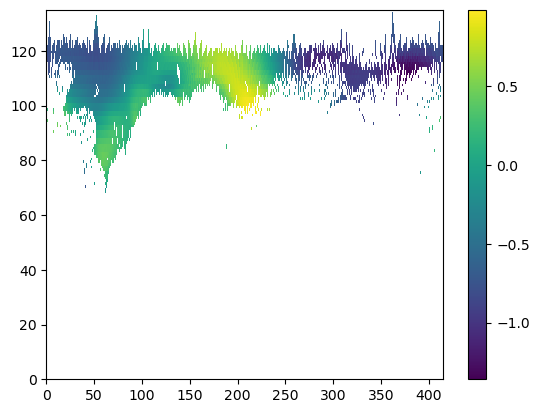

In [19]:
plt.pcolormesh(upred[0,:,:])
plt.colorbar()
plt.show()

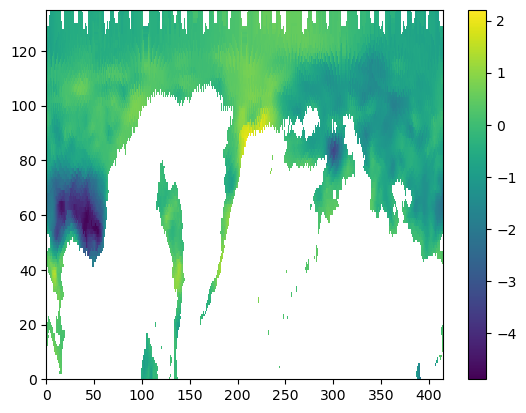

In [20]:
plt.pcolormesh(utrue[0,:,:])
plt.colorbar()
plt.show()

In [ ]:
def lr_train_ridge(x_train, y_train):

    # TODO dynamic number of input channels and coefficients

    # Define number of input channels for gram matrix
    nin = 3 # complex wind (za), complex ice concentration (zci), complex constant 

    # Define number of complex coefficients
    nzm = 3 # A, B, C
   
    # Get dimensions for output arrays
    nt, _, nlat, nlon = np.shape(y_train)

    # Unpack target arrays
    ui_t0 = y_train[:,0,:,:]
    vi_t0 = y_train[:,1,:,:]

    # Unpack feature arrays
    ua_t0 = x_train[:,0,:,:]
    va_t0 = x_train[:,1,:,:]
    ci_t1 = x_train[:,2,:,:]

    # TODO fix nin for zm_all (just a coincidence that it matches with nin)
    # need A, B, C (za, ua, constant)

    # TODO switch order of gram matrix so constant is at end?
    # for consisitency with lr equation Ax + Bx + C

    # Initialize output arrays
    ztrue_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # true present day ice velocity vector, complex
    zfit_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # present day fit ice velocity, complex
    zm_all = np.full((nzm, nlat, nlon), np.nan, dtype = complex) # lr coefficients (A, B, C), complex
    
    # Iterate through each latitude, longitude gridpoint
    for ilat in range(nlat):
        for ilon in range(nlon):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))):
                continue

            else:
                # Handle missing data
                
                # Initialize mask for valid values
                true_mask = np.ones_like(ui_t0[:,ilat,ilon], dtype=bool) # 1 = True = Inclusion

                # Set 'True' for indices with nan values, 'False' for valid
                inan = np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))

                # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                true_mask = ~inan

                # Filter inputs to valid indices
                ui_t0_filt = ui_t0[true_mask,ilat,ilon]
                vi_t0_filt = vi_t0[true_mask,ilat,ilon]
                ua_t0_filt = ua_t0[true_mask,ilat,ilon]
                va_t0_filt = va_t0[true_mask,ilat,ilon]
                ci_t1_filt = ci_t1[true_mask,ilat,ilon]

                # Convert to complex
                zi_t0 = ui_t0_filt + vi_t0_filt*1j # Complex 'today' ice velocity vector       
                za_t0 = ua_t0_filt + va_t0_filt*1j # Complex 'today' wind vector
                zci_t1 = ci_t1_filt + ci_t1_filt*1j # Complex 'yesterday' ice concentration
                
                # Store true complex ice velocity vectors at valid points
                ztrue_all[true_mask, ilat, ilon] = zi_t0

                # Define size of valid batch at current grid point
                nt_ij = len(ui_t0_filt)

                # Define gram matrix
                G = np.ones(((nt_ij, nin)), dtype = complex) 

                G[:,0] = za_t0 # Present day wind velocity, complex
                G[:,1] = zci_t1 # Previous day ice concentration, complex
                
                # NOTE last column of G constant

                # Define data matrix
                d = zi_t0.T

                # Define ridge parameter
                lmda = 1e-2

                # Initialize Identity matrix
                I = identity(nin, dtype = complex)

                # Solve for lr coefficients
                zm = (LA.inv((G.conj().T @ G + lmda*I))) @ G.conj().T @ d

                # Save lr coefficients
                for izm in range(len(zm)):
                    zm_all[izm, ilat, ilon] = zm[izm]

                # Calculate fit
                zfit = G @ zm
                
                # Store predicted complex ice velocity vectors at valid points
                zfit_all[true_mask, ilat, ilon] = zfit


        print(f'lat {ilat} complete')
        
    return zm_all, zfit_all, ztrue_all

In [ ]:
def lr_test(x_test, y_test, zm):

    # TODO dynamic number of input channels and coefficients

    # Define number of input channels for gram matrix
    nin = 3 # complex wind (za), complex ice concentration (zci), complex constant 
   
    # Get dimensions for output arrays
    nt, _, nlat, nlon = np.shape(y_test)

    # Unpack target arrays
    ui_t0 = y_test[:,0,:,:]
    vi_t0 = y_test[:,1,:,:]

    # Unpack feature arrays
    ua_t0 = x_test[:,0,:,:]
    va_t0 = x_test[:,1,:,:]
    ci_t1 = x_test[:,2,:,:]
      
    # Initialize output arrays
    ztrue_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    zpred_all = np.full((nt, nlat, nlon), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    
    # Iterate through each latitude, longitude gridpoint
    for ilat in range(nlat):
        for ilon in range(nlon):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))):
                continue

            else:
                # Handle missing data
                
                # Initialize mask for valid values
                true_mask = np.ones_like(ui_t0[:,ilat,ilon], dtype=bool) # 1 = True = Inclusion

                # Set 'True' for indices with nan values, 'False' for valid
                inan = np.logical_or(np.isnan(ui_t0[:,ilat,ilon]), np.isnan(vi_t0[:,ilat,ilon]))

                # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                true_mask = ~inan

                # Filter inputs to valid indices
                ui_t0_filt = ui_t0[true_mask,ilat,ilon]
                vi_t0_filt = vi_t0[true_mask,ilat,ilon]
                ua_t0_filt = ua_t0[true_mask,ilat,ilon]
                va_t0_filt = va_t0[true_mask,ilat,ilon]
                ci_t1_filt = ci_t1[true_mask,ilat,ilon]

                # Convert to complex
                zi_t0 = ui_t0_filt + vi_t0_filt*1j # Complex 'today' ice velocity vector       
                za_t0 = ua_t0_filt + va_t0_filt*1j # Complex 'today' wind vector
                zci_t1 = ci_t1_filt + ci_t1_filt*1j # Complex 'yesterday' ice concentration
                
                # Store true complex ice velocity vectors at valid points
                ztrue_all[true_mask, ilat, ilon] = zi_t0

                # Define size of valid batch at current grid point
                nt_ij = len(ui_t0_filt)

                # Define gram matrix
                G = np.ones(((nt_ij, nin)), dtype = complex) 

                G[:,0] = za_t0 # Present day wind velocity, complex
                G[:,1] = zci_t1 # Previous day ice concentration, complex
                
                # NOTE last column of G constant

                # Define data matrix
                d = zi_t0.T

                # Get valid coefficients at grid point
                zm_ij = zm[:,ilat,ilon]

                # Calculate fit
                zpred = G @ zm_ij
        
                # Store predicted complex ice velocity vectors at valid points
                zpred_all[true_mask, ilat, ilon] = zpred


        print(f'ilat {ilat} complete')

    return zpred_all, ztrue_all

In [29]:
# Get train batch dimensions
nt_tr, nout, nlat, nlon = np.shape(y_train)

# Get input channel dimensions
_, nin, _, _, = np.shape(x_train)

# TODO make coefficient dimension dynamic

# Get coefficient dimension
nm = nin + 1 # NOTE +1 for u and v complex concentration projections 
nm = nm + 2 # NOTE +2 for u and v constants (mean ~ 0) (constant column G[0])

# Get test batch dimensions
nt_te, _, _, _ = np.shape(y_test)

# Train model
zm, zfit_tr, ztrue_tr = lr_train_ridge(x_train, y_train)

# Initialize arrays for real training outputs
# NOTE two extra coefficients for u and v mean
m = np.full((nm, nlat, nlon), np.nan) # model coefficients, real
fit_tr = np.full((nt_tr, nout, nlat, nlon), np.nan) # training fit, real
true_tr = np.full((nt_tr, nout, nlat, nlon), np.nan) # training true, real

# TODO make loop or use advanced indexing for real and imaginary coefficients

# Convert training coefficients to real
m[0, :, :] = zm[0, :, :].real # C_uproj, (constant)
m[1, :, :] = zm[0, :, :].imag # C_vproj, (constant)
m[2, :, :] = zm[1, :, :].real # A_uproj, (ua_t0)
m[3, :, :] = zm[1, :, :].imag # A_uproj, (va_t0)
m[4, :, :] = zm[2, :, :].real # B_uproj, (ci_t1)
m[5, :, :] = zm[2, :, :].imag # B_uproj, (ci_t1)

# Convert training fit to real
fit_tr[:, 0, :, :] = zfit_tr.real # ui_t0, fit
fit_tr[:, 1, :, :] = zfit_tr.imag # vi_t0, fit

# Convert training true to real
true_tr[:, 0, :, :] = ztrue_tr.real # ui_t0, true
true_tr[:, 1, :, :] = ztrue_tr.imag # vi_t0, true

# # Save coeffients, fit
# np.savez(
#     os.path.join(PATH_DEST, f"coef_fit_{MODEL_STR}_{FSTR_END_OUT}.npz"),
#     m = m,
#     fit_tr = fit_tr,
#     true_tr = true_tr,
# )

Error at lat=0, lon=0: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=1: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=2: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=3: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=4: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=5: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=6: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=7: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=8: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=9: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=10: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=11: only length-1 arrays can be converted to Python scalars
Error at lat=0, lon=12: only length-1 arrays can b

KeyboardInterrupt: 

In [ ]:
# Get predictions on test set
zpred_te, ztrue_te = lr_test(x_test, y_test, zm)

# Intialize arrays for test output predictions
# NOTE y notation used for consistency with CNN and plotting
y_pred = np.full((nt_te, nout, nlat, nlon), np.nan) 
y_true = np.full((nt_te, nout, nlat, nlon), np.nan)

# Convert test predictions to real
y_pred[:,0,:,:] = zpred_te.real # ui_t0, pred
y_pred[:,1,:,:] = zpred_te.imag # vi_t0, pred

# Convert test true to real
y_true[:,0,:,:] = ztrue_te.real # ui_t0, true
y_true[:,1,:,:] = ztrue_te.imag # vi_t0, true

# # Save predictions
# np.savez(
#     os.path.join(PATH_DEST, f"preds_{MODEL_STR}_{FSTR_END_OUT}.npz"),
#     y_pred = y_pred,
#     y_true = y_true,
# )

In [ ]:
upred = y_pred[:,0,:,:]
vpred = y_pred[:,1,:,:]

utrue = y_true[:,0,:,:]
vtrue = y_true[:,1,:,:]

plt.pcolormesh(upred[0,:,:])
plt.colorbar()
plt.show()

plt.pcolormesh(utrue[0,:,:])
plt.colorbar()
plt.show()